In [12]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import math
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc
import sklearn
import sklearn.linear_model
import sklearn.decomposition

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from timecast.learners import ARXHistory
from timecast.optim import GradientDescent
from timecast import tscan

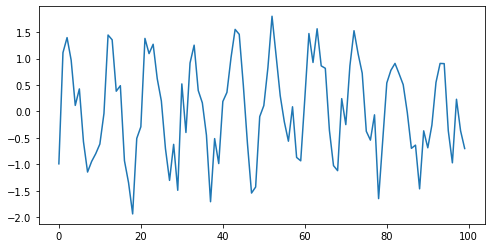

In [18]:
# data generator sinusoid + white noise
plt.rc('figure', figsize=(8,4))

def datagen(length, period, noise_level, seed):
    t = np.linspace(0, length-1, length)
    x = np.sin(2*np.pi/period * t)
    noise = jax.random.normal(jax.random.PRNGKey(seed), (length,)) * noise_level
    return x + noise

x = datagen(100,10,0.5,0)
plt.plot(x)

(80, 20) (80,)


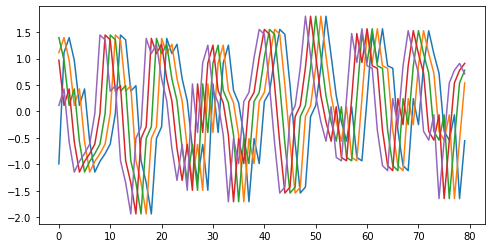

In [153]:
# generate sliding windows
plt.rc('figure', figsize=(8,4))

def AR_feat(x, H):
  X, Y = [], []
  for i in range(H, len(x)):
    X.append(x[i-H:i])
    Y.append(x[i])
  return np.array(X), np.array(Y)

X, Y = AR_feat(x, 20)
print(X.shape, Y.shape)
for i in range(5):
  plt.plot(X[:,i])

In [229]:
train_length = 100
test_length = 100
period = 10
noise_level = 0.5

x_train = datagen(train_length, period, noise_level, 0)
x_test = datagen(test_length, period, noise_level, 3)

In [155]:
def viz(truth, pred, title, **kwargs):
  plt.title(title)
  plt.plot(truth, color='gray')
  plt.plot(np.arange(len(truth)-len(pred), len(truth)), pred, **kwargs)

def trunc_mse(truth, pred):
  # compute truncated MSE, with shorter array of predictions
  return np.mean( (truth[len(truth)-len(pred):]-pred)**2 )

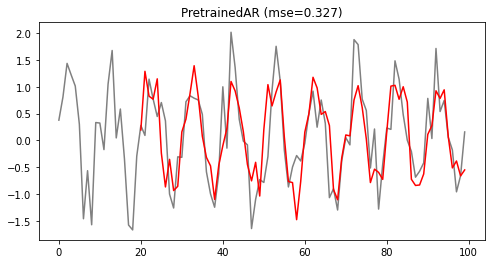

In [230]:
# Pre-trained AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedAR(x_train, x_test, H):
  X_train, Y_train = AR_feat(x_train, H)
  X_test, Y_test = AR_feat(x_test, H)
  
  ls = sklearn.linear_model.Ridge(1e-20)
  ls.fit(X_train, Y_train)
  Y_pred = ls.predict(X_test)

  err = trunc_mse(Y_test, Y_pred)
  viz(x_test, Y_pred, title='PretrainedAR (mse=%.3f)' % err, color='red')

  return err

_ = TestPretrainedAR(x_train, x_test, 20)

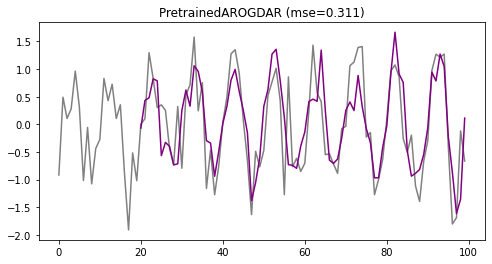

In [157]:
# Pre-trained AR, OGD AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedAROGDAR(x_train, x_test, H):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
  
    ls = sklearn.linear_model.Ridge(1e-20)
    ls.fit(X_train, Y_train)
    
    model, state = ARXHistory.new(shapes=[(1, H, 1)])
    model.params["Targets"]["Linear"]["kernel"] = ls.coef_[:, None]
    model.params["Targets"]["Linear"]["bias"] = jnp.array(np.array([ls.intercept_]))
    optim_def = GradientDescent(learning_rate=10**-2)
    optimizer = optim_def.create(model)
    
    Y_pred, optimizer, state = tscan(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1), Y_test, optimizer, state=state)
    Y_pred = Y_pred.squeeze()

    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='PretrainedAROGDAR (mse=%.3f)' % err, color='purple')

    return err

_ = TestPretrainedAROGDAR(x_train, x_test, 20)

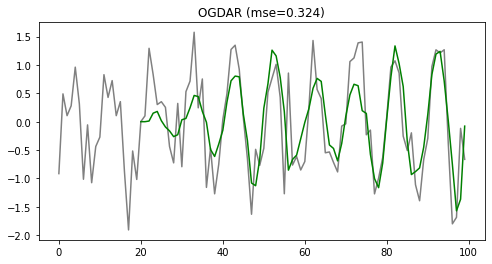

In [158]:
# OGD AR
plt.rc('figure', figsize=(8,4))

def TestOGDAR(x_train, x_test, H):
    X_test, Y_test = AR_feat(x_test, H)
    model, state = ARXHistory.new(shapes=[(1, H, 1)])
    optim_def = GradientDescent(learning_rate=10**-2)
    optimizer = optim_def.create(model)
    
    Y_pred, optimizer, state = tscan(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1), Y_test, optimizer, state=state)
    Y_pred = Y_pred.squeeze()
    
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OGDAR (mse=%.3f)' % err, color='green')
    return err
    
_ = TestOGDAR(x_train, x_test, 20)

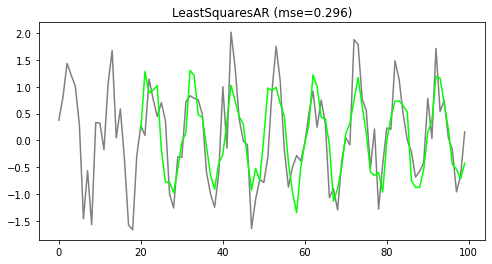

In [231]:
# Least Squares AR
plt.rc('figure', figsize=(8,4))

def TestLeastSquaresAR(x_train, x_test, H):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    ls = sklearn.linear_model.Ridge(1e-20)
    ls.fit(X_train, Y_train)
    
    Y_pred = []
    for x, y in zip(X_test, Y_test):
        X_train, Y_train = list(X_train), list(Y_train)
        
        Y_pred.append(ls.predict(x.reshape(1, -1)))
        
        X_train.append(x)
        Y_train.append(y)
        ls = sklearn.linear_model.Ridge(1e-20)
        
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        ls.fit(X_train, Y_train)

    err = trunc_mse(Y_test, np.array(Y_pred).squeeze())
    viz(x_test, Y_pred, title='LeastSquaresAR (mse=%.3f)' % err, color='lime')

    return err
    
err = TestLeastSquaresAR(x_train, x_test, 20)

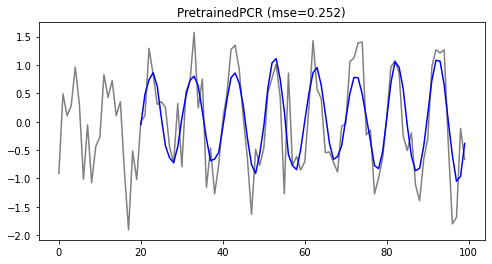

In [187]:
# Pre-trained PCR
plt.rc('figure', figsize=(8,4))

def TestPretrainedPCR(x_train, x_test, H, k):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)

    pca = sklearn.decomposition.PCA(k)
    ls = sklearn.linear_model.Ridge(1e-20)

    ls.fit(pca.fit_transform(X_train), Y_train)
    Y_pred = ls.predict(pca.transform(X_test))

    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='PretrainedPCR (mse=%.3f)' % err, color='blue')
    return err

_ = TestPretrainedPCR(x_train, x_test, 20, 2)

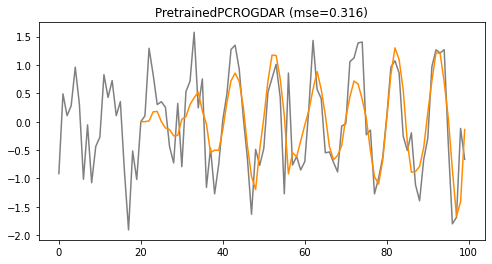

In [197]:
# Pre-trained PCR, OGD AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedPCROGDAR(x_train, x_test, H, k):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)

    pca = sklearn.decomposition.PCA(k)
    pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    model, state = ARXHistory.new(shapes=[(1, k, 1)])
    optim_def = GradientDescent(learning_rate=10**-2)
    optimizer = optim_def.create(model)
    
    Y_pred, optimizer, state = tscan(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1), Y_test, optimizer, state=state)
    Y_pred = Y_pred.squeeze()

    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='PretrainedPCROGDAR (mse=%.3f)' % err, color='darkorange')
    return err

_ = TestPretrainedPCROGDAR(x_train, x_test, 20, 2)

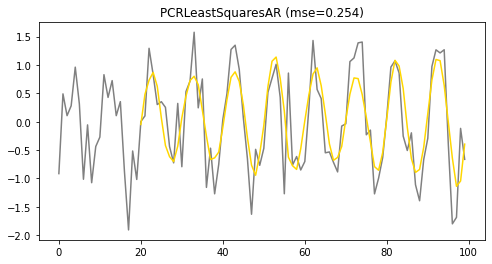

In [220]:
# Online PCR, Least Squares AR
plt.rc('figure', figsize=(8,4))

def TestPCRLeastSquaresAR(x_train, x_test, H, k):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)

    pca = sklearn.decomposition.PCA(k)
    pca.fit_transform(X_train)
    
    ls = sklearn.linear_model.Ridge(1e-20)
    ls.fit(pca.fit_transform(X_train), Y_train)

    Y_pred = []
    for x, y in zip(X_test, Y_test):
        X_train, Y_train = list(X_train), list(Y_train)
        
        Y_pred.append(ls.predict(pca.transform(x.reshape(1, -1))))
        
        X_train.append(x)
        Y_train.append(y)
        pca = sklearn.decomposition.PCA(k)
        
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        pca.fit_transform(X_train)

        ls = sklearn.linear_model.Ridge(1e-20)
        ls.fit(pca.fit_transform(X_train), Y_train)

    err = trunc_mse(Y_test, np.array(Y_pred).squeeze())
    viz(x_test, Y_pred, title='PCRLeastSquaresAR (mse=%.3f)' % err, color='gold')
    return err

_ = TestPCRLeastSquaresAR(x_train, x_test, 20, 2)

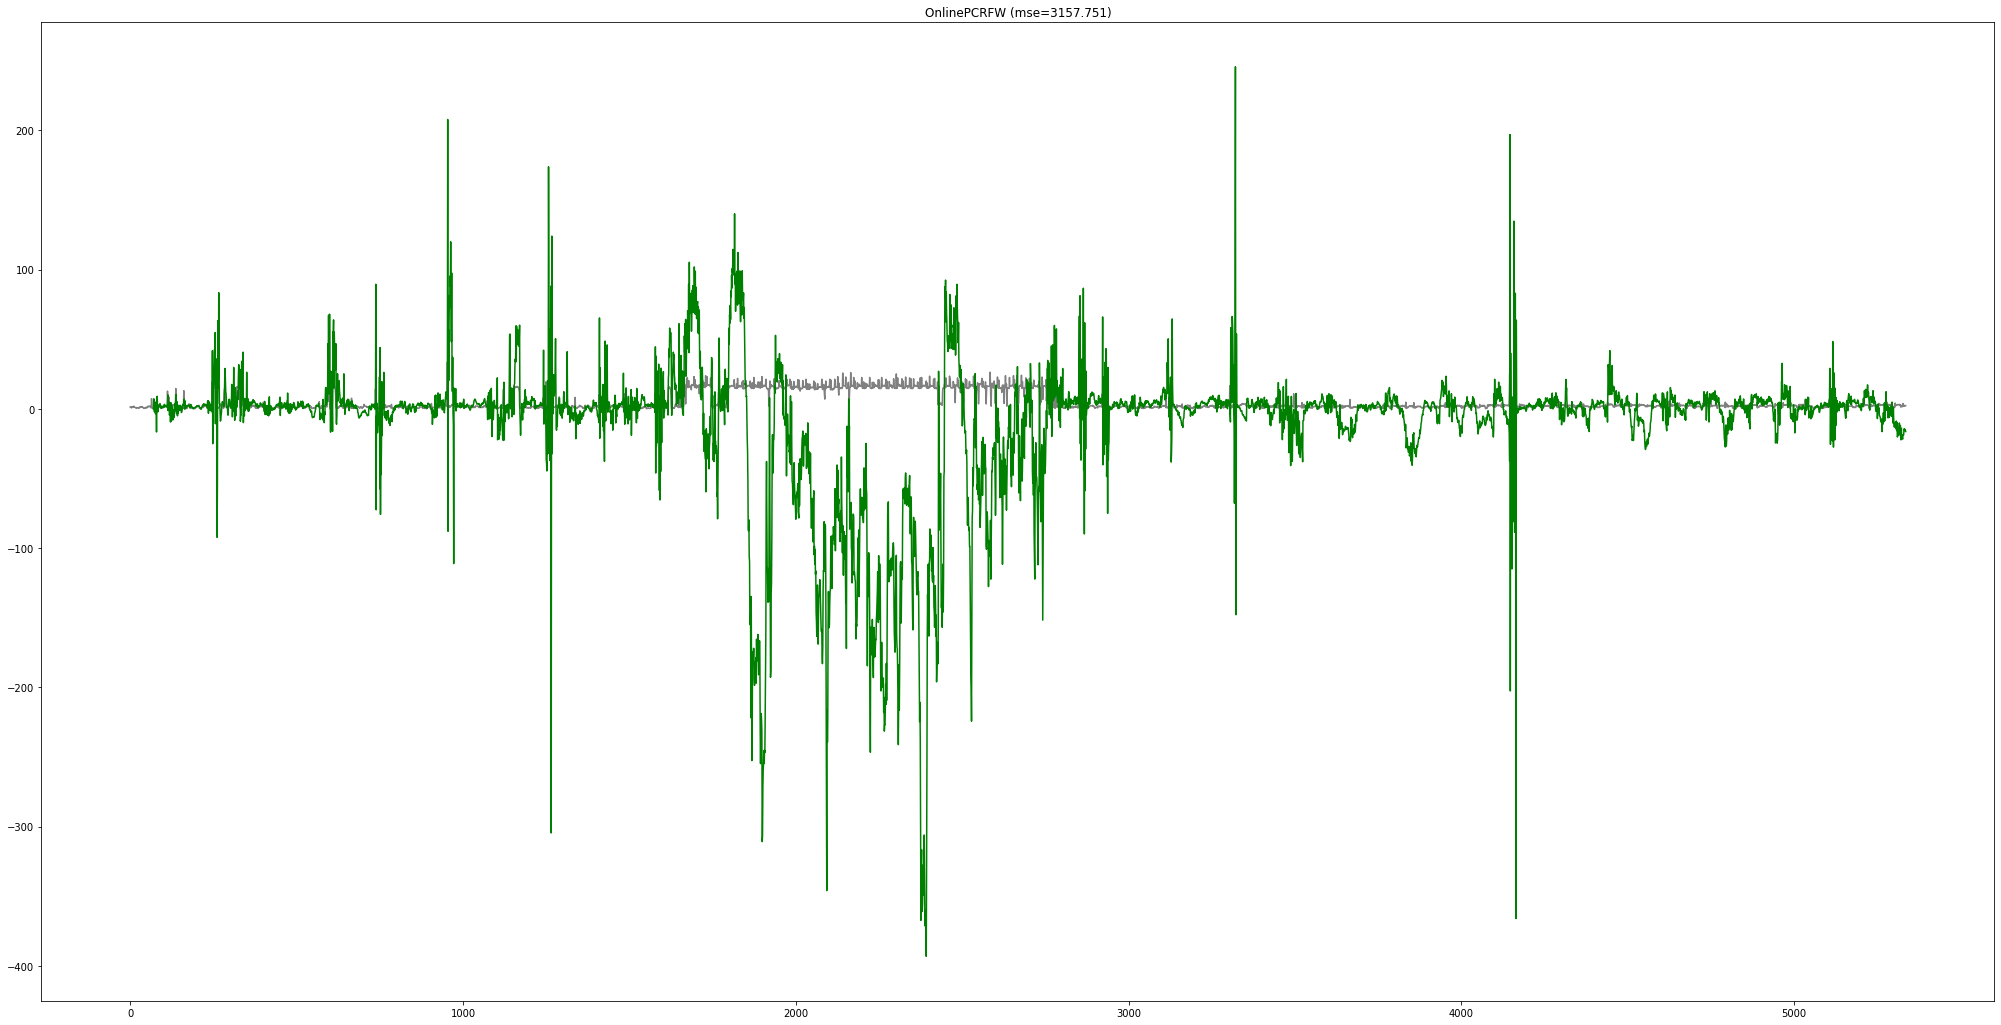

In [237]:
# OnlinePCR, Frank-Wolfe

"""
𝛂 (jnp.ndarray): a vector of length W
x (jnp.ndarray): true values from 0 to W - 1
𝛘 (jnp.ndarray): W histories with d * H dimensions
B (jnp.ndarray): Projection matrix from d * H dimensions to d * H dimensions
𝜆 (float): regularization factor

𝜑(𝛂, B) = 𝓁(-𝜆 * W * 𝛂, x) / W + 𝜆 / 2 * 𝛂.T @ 𝛘 @ B @ 𝛘.T @ 𝛂

d𝜑(𝛂, B)/d𝛂 = (-𝜆 * W * 𝛂 - x) / W + 𝜆 * 𝛘 @ B @ 𝛘.T @ 𝛂
            = 0
            
𝛂 = (I - 𝛘 @ B @ 𝛘.T)^-1 @ (-x / (W * 𝜆))
"""

def min_𝛂(x, 𝛘, B, W, 𝜆):
    XBX = 𝛘 @ B @ 𝛘.T
    inv = jnp.linalg.pinv(jnp.eye(XBX.shape[0]) - XBX)
    return inv @ (-x / (W * 𝜆))

def grad_phi_B(𝛂, 𝛘, 𝜆):
    return - 𝜆 / 2 * jnp.outer(𝛂 @ 𝛘, 𝛂 @ 𝛘)

def grad_F_B(B, G, 𝛽, 𝜂, B0):
    return 𝜂 * G + 𝛽 * (B - B0)

def TestOnlinePCRFW(x_train, x_test, H, W):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    d = 1
    C = 1
    B = jnp.eye(d * H)
    B0 = B
    G = jnp.zeros_like(B0)
    𝜆 = 1000

    T = X_test.shape[0]
    
    Y_pred = []
    
    for t in tqdm.tqdm(range(W, T)):
        eigvals, eigvecs = jnp.linalg.eigh(B)
        M = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T
#         M = B
        
        ls = sklearn.linear_model.Ridge(𝜆)
        ls.fit(X_test[t - W:t] @ M.T, Y_test[t - W:t])
        
        Y_pred.append(ls.predict(X_test[t].reshape(1, -1))[0])
        
        𝛂 = min_𝛂(Y_test[t - W + 1:t + 1], X_test[t - W + 1:t + 1], B, W, 𝜆)
        
        g = grad_phi_B(𝛂, X_test[t - W + 1 : t + 1], 𝜆)
        G += g
        
        FB = grad_F_B(B, G, 4 / (𝜆 * (t ** 1/4)), 1 / jnp.sqrt(t + 1), B0)
        
        eigvals, eigvecs = jax.scipy.linalg.eigh(-FB)
        v = eigvecs[np.argmax(eigvals)]
        
        𝛾 = 1 / t
        B = 𝛾 * C * jnp.outer(v, v) + (1 - 𝛾) * B
        
        print(jnp.linalg.norm(G), trunc_mse(Y_test[:len(Y_pred)], Y_pred))
        
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OnlinePCRFW (mse=%.3f)' % err, color='green')
    return err, Y_pred

err, Y_pred = TestOnlinePCRFW(x_train, x_test, H, W)

In [244]:
# OnlinePCR, MW

"""
𝛂 (jnp.ndarray): a vector of length W
x (jnp.ndarray): true values from 0 to W - 1
𝛘 (jnp.ndarray): W histories with d * H dimensions
B (jnp.ndarray): Projection matrix from d * H dimensions to d * H dimensions
𝜆 (float): regularization factor

𝜑(𝛂, B) = 𝓁(-𝜆 * W * 𝛂, x) / W + 𝜆 / 2 * 𝛂.T @ 𝛘 @ B @ 𝛘.T @ 𝛂

d𝜑(𝛂, B)/d𝛂 = (-𝜆 * W * 𝛂 - x) / W + 𝜆 * 𝛘 @ B @ 𝛘.T @ 𝛂
            = 0
            
𝛂 = (I - 𝛘 @ B @ 𝛘.T)^-1 @ (-x / (W * 𝜆))
"""

def min_𝛂(x, 𝛘, B, W, 𝜆):
    XBX = 𝛘 @ B @ 𝛘.T
    inv = jnp.linalg.pinv(jnp.eye(XBX.shape[0]) - XBX)
    return inv @ (-x / (W * 𝜆))

def grad_f_B(𝛂, 𝛘, 𝜆):
    return - 𝜆 / 2 * jnp.outer(𝛂 @ 𝛘, 𝛂 @ 𝛘)

def TestOnlinePCRMW(x_train, x_test, H, W):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    d = 1
    C = 1
    B = jnp.eye(d * H) / (d * H)
    P = jnp.zeros_like(B)
    𝜆 = 1000

    T = X_test.shape[0]
    
    𝜂 = 𝜆 / jnp.sqrt(T)
    𝜂 = 0
    
    Y_pred = []
    
    for t in tqdm.tqdm(range(W, T)):
        eigvals, eigvecs = jnp.linalg.eigh(B)
        M = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T

        ls = sklearn.linear_model.Ridge(𝜆)
        ls.fit(X_test[t - W:t] @ M.T, Y_test[t - W:t])
        
        Y_pred.append(ls.predict(X_test[t].reshape(1, -1))[0])
        
        𝛂 = min_𝛂(Y_test[t - W + 1:t + 1], X_test[t - W + 1:t + 1], B, W, 𝜆)
        
        p = grad_f_B(𝛂, X_test[t - W + 1 : t + 1], 𝜆)
        P += p
        eigvals, eigvecs = jnp.linalg.eigh(P)
        
        exp = jnp.exp(-𝜂 * eigvals)
#         print(min(eigvals), max(eigvals))
        
        v = eigvecs @ jnp.diag(exp) @ eigvecs.T
#         B = v / exp.sum()
        
        print(trunc_mse(Y_test[:len(Y_pred)], np.asarray(Y_pred).flatten()))
        
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OnlinePCRMW (mse=%.3f)' % err, color='green')
    return err, Y_pred

err, Y_pred = TestOnlinePCRMW(x_train, x_test, H, W)

NameError: name 'W' is not defined

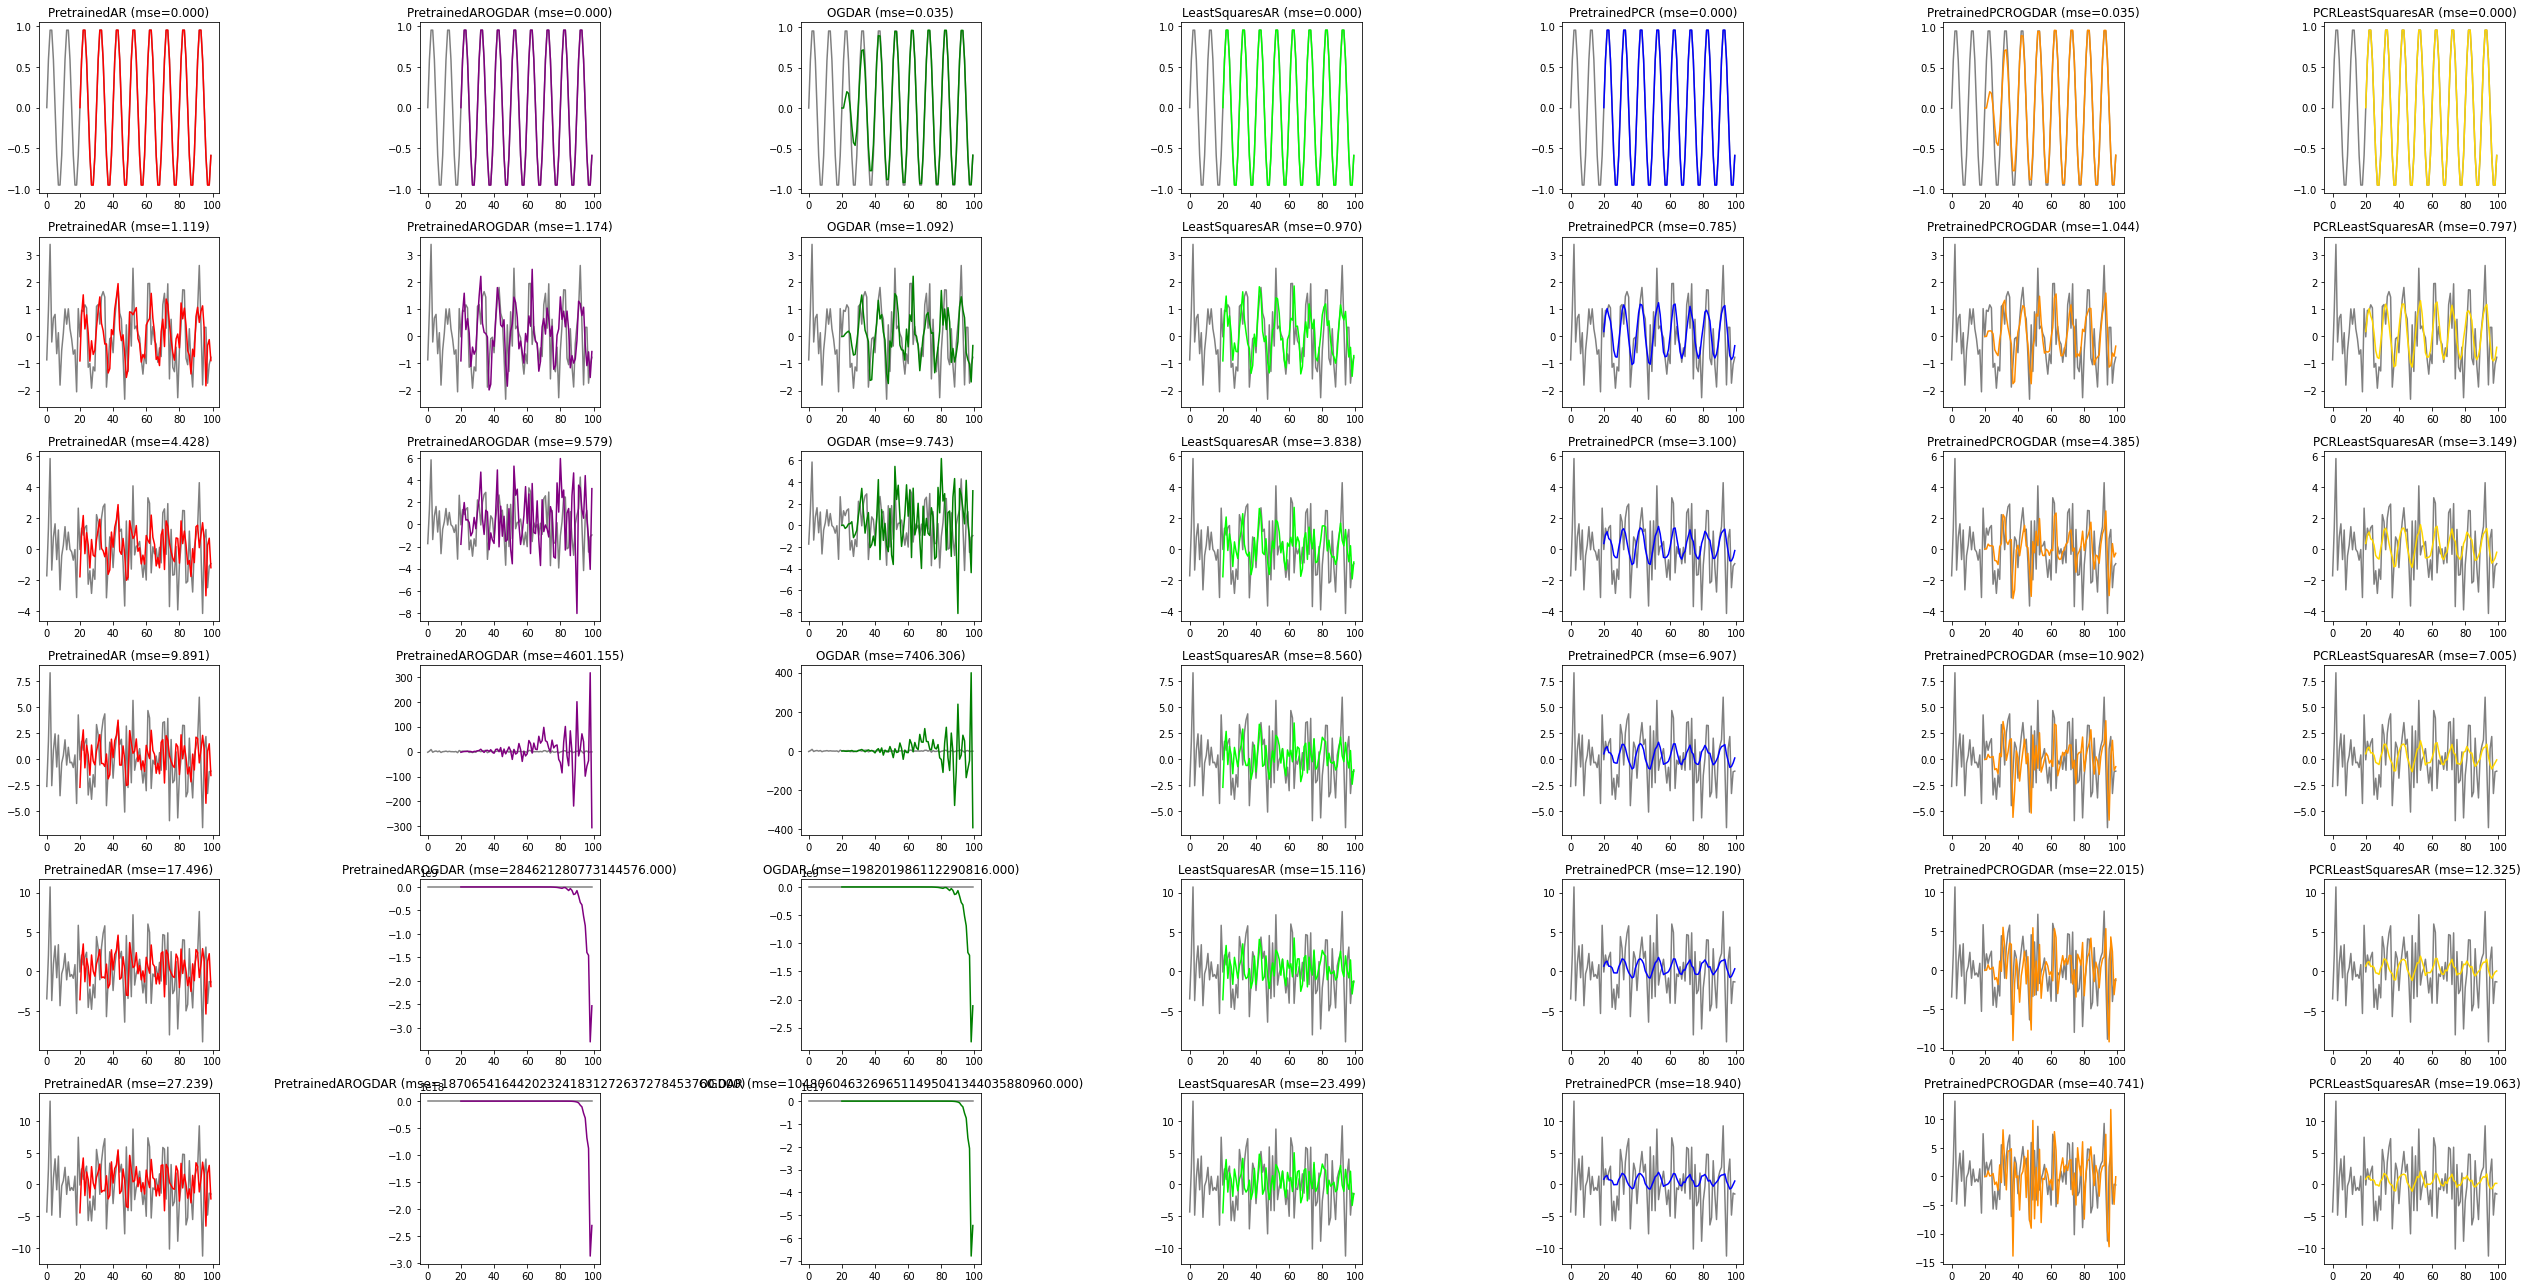

In [221]:
# wiggle the noise level

train_length = 100
test_length = 100
period = 10
noise_levels = np.linspace(0, 4, 6)

H = 20
k = 2

loss_table = []

num_figs = 7

plt.rc('figure', figsize=(num_figs * 5, 3*len(noise_levels)))

for i,noise_level in enumerate(noise_levels):
    x_train = datagen(train_length, period, noise_level, 0)
    x_test = datagen(test_length, period, noise_level, 124)
    x_pure = datagen(test_length, period, 0, 2)

    plt.subplot(len(noise_levels), num_figs, num_figs*i+1)
    loss_pretrained_ar = TestPretrainedAR(x_train, x_test, H)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+2)
    loss_pretrained_ar_ogd_ar = TestPretrainedAROGDAR(x_train, x_test, H)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+3)
    loss_ogd_ar = TestOGDAR(x_train, x_test, H)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+4)
    loss_least_squares_ar = TestLeastSquaresAR(x_train, x_test, H)

    plt.subplot(len(noise_levels), num_figs, num_figs*i+5)
    loss_pretrained_pcr = TestPretrainedPCR(x_train, x_test, H, k)

    plt.subplot(len(noise_levels), num_figs, num_figs*i+6)
    loss_pretrained_pcr_ogd_ar = TestPretrainedPCROGDAR(x_train, x_test, H, k)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+7)
    loss_pcr_least_squares_ar = TestPCRLeastSquaresAR(x_train, x_test, H, k)
    
    loss_pure = trunc_mse(x_test, x_pure[H:])

    loss_table.append( [loss_pretrained_ar,
                        loss_pretrained_ar_ogd_ar,
                        loss_ogd_ar,
                        loss_least_squares_ar,
                        loss_pretrained_pcr,
                        loss_pretrained_pcr_ogd_ar,
                        loss_pcr_least_squares_ar,
                        loss_pure] )

loss_table = np.array(loss_table)
plt.tight_layout()

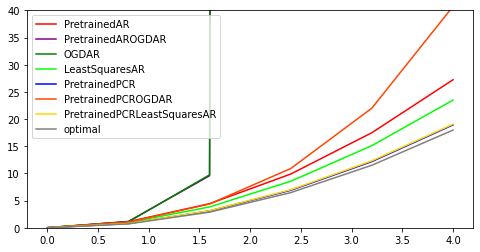

In [204]:
# plot losses from above

plt.rc('figure', figsize=(8,4))
colors = ["red", "purple", "green", "lime", "blue", "orangered", "gold", "gray"]
labels = ['PretrainedAR', 'PretrainedAROGDAR', 'OGDAR', 'LeastSquaresAR', 'PretrainedPCR','PretrainedPCROGDAR', 'PretrainedPCRLeastSquaresAR', 'optimal']
for i in range(num_figs + 1):
    plt.plot(noise_levels, loss_table[:,i], color=colors[i], label=labels[i])

plt.ylim((0, 40))
plt.legend()

# tspdb

Let's now load and preprocess the data. Specifically we will:

1- Pick the first 20 houses MT-001to MT-020

1- Aggregate the data into hourly readings by avergaing the 15-minutes readings.

2- Remove the data before 2011, since most of its readings are zeros

In [206]:
data = pd.read_csv('../data/tspdb/LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:21]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
data_3 = data_2.groupby(['time']).agg(agg_dict)
print('data aggregated..')

data loaded..
data aggregated..


Now each column of the dataframe data_3 contains hourly reading starting from 2012-01-01 01:00 until 2015-01-01 01:00. In this experiment, as mentioned before, we will split the observations into a training and testing sets. Specifically, the training set will start at 2012-01-01 01:00 until 2014-12-18 00:00. and the test set will have the rest of the observations.

Splitting the data into training and testing sets:

NOTE: We turn this into univariate data for now

In [232]:
# cutoff = 25968
cutoff = 20968
# x_train = np.array(data_3.iloc[:cutoff]).sum(axis=1)
# x_test = np.array(data_3.iloc[cutoff:]).sum(axis=1)

x_train = np.array(data_3.iloc[:cutoff])[:, 0]
x_test = np.array(data_3.iloc[cutoff:])[:, 0]

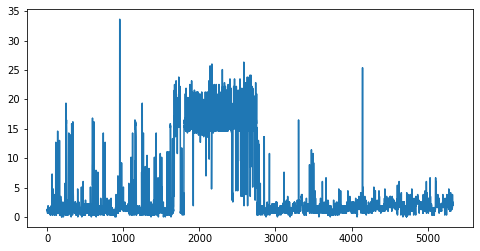

In [234]:
plt.plot(x_test)

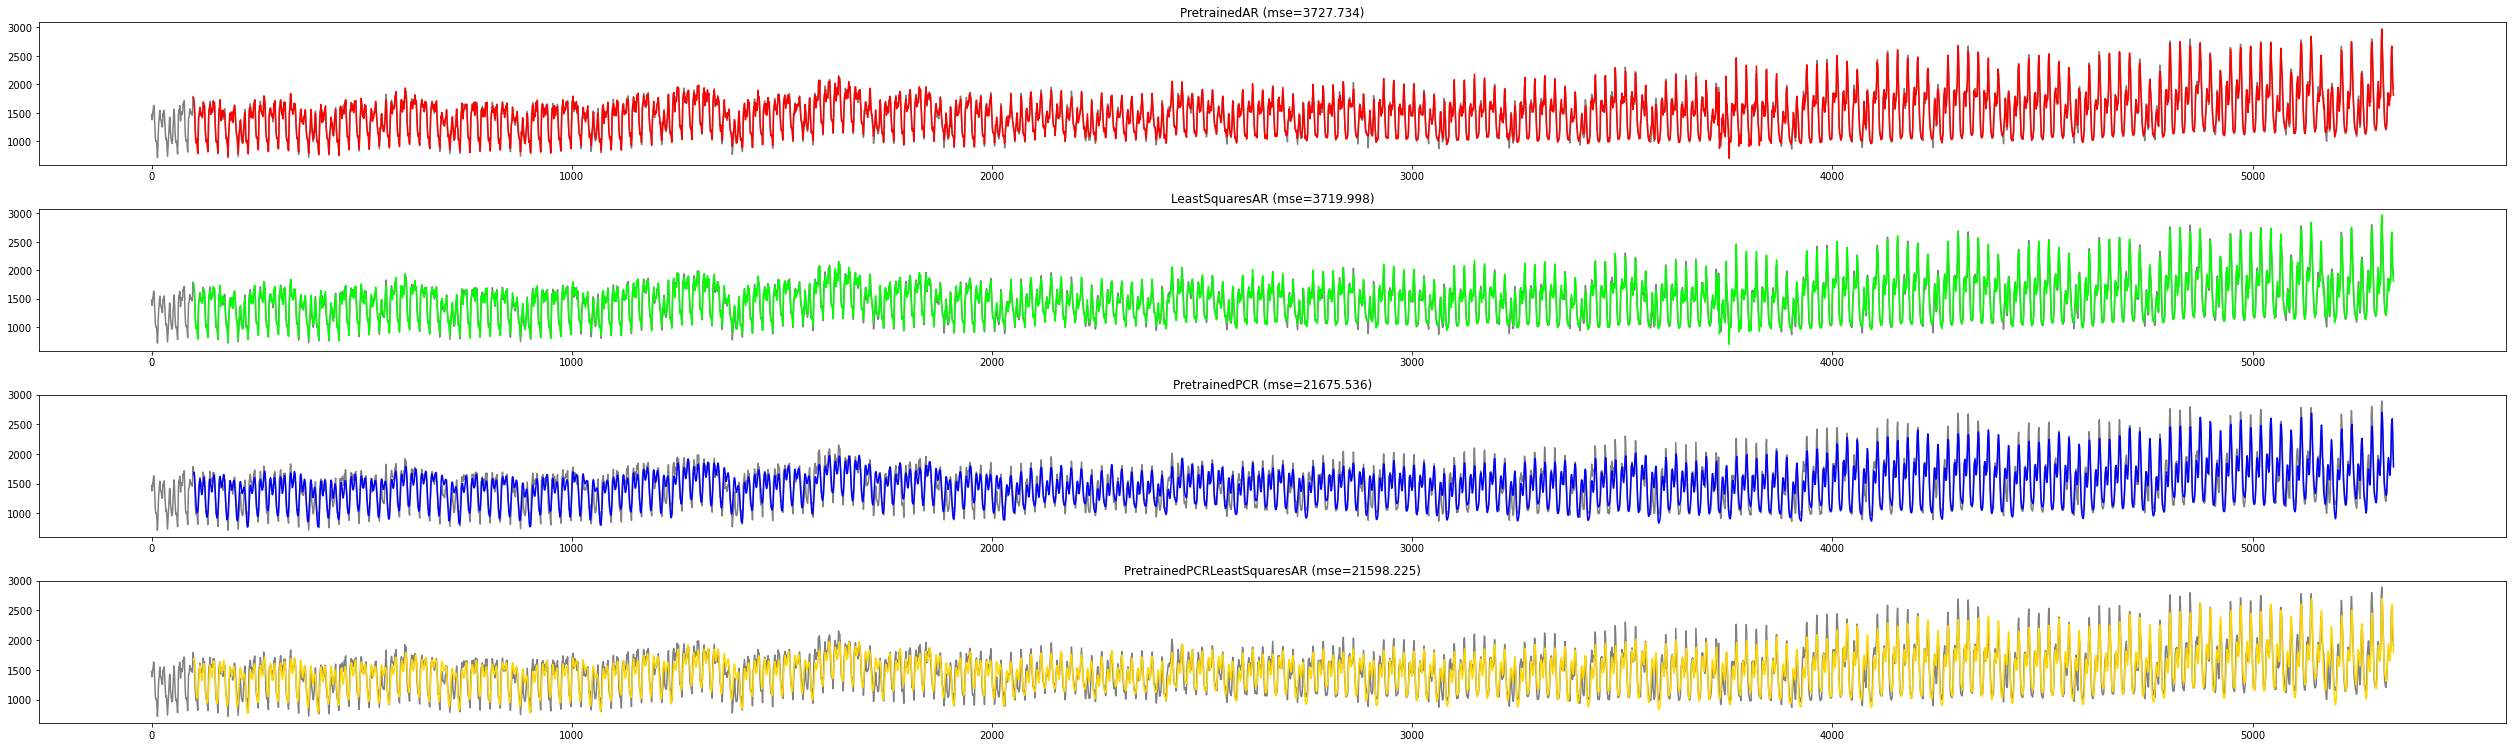

In [216]:
H = 100
k = 10

loss_table = []

num_figs = 7

plt.rc('figure', figsize=(num_figs * 5, 3*len(noise_levels)))

plt.subplot(num_figs, 1, 1)
loss_pretrained_ar = TestPretrainedAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 2)
loss_least_squares_ar = TestLeastSquaresAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 3)
loss_pretrained_pcr = TestPretrainedPCR(x_train, x_test, H, k)

plt.subplot(num_figs, 1, 4)
loss_pretrained_pcr_least_squares_ar = TestPretrainedPCRLeastSquaresAR(x_train, x_test, H, k)

loss_pure = trunc_mse(x_test, x_pure[H:])

loss_table.append( [loss_pretrained_ar,
                    loss_least_squares_ar,
                    loss_pretrained_pcr,
                    loss_pretrained_pcr_least_squares_ar,
                    loss_pure] )

loss_table = np.array(loss_table)
plt.tight_layout()

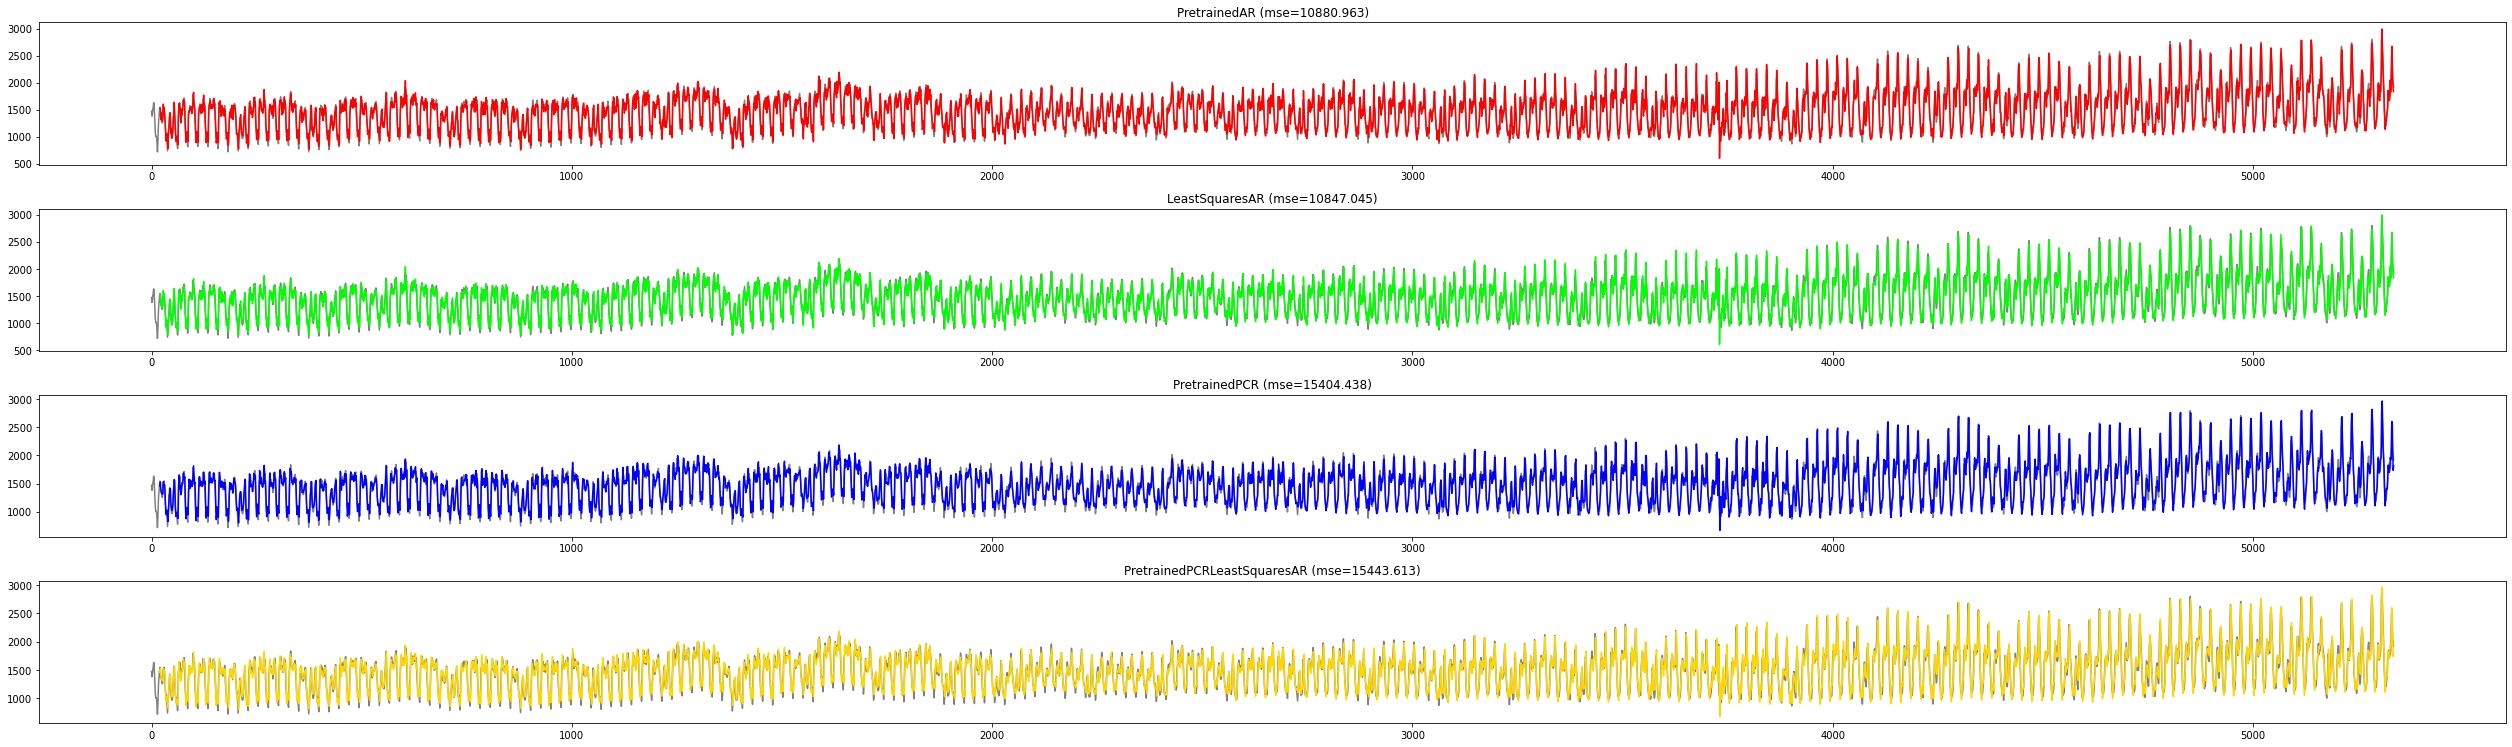

In [217]:
H = 20
k = 10

loss_table = []

num_figs = 7

plt.rc('figure', figsize=(num_figs * 5, 3*len(noise_levels)))

plt.subplot(num_figs, 1, 1)
loss_pretrained_ar = TestPretrainedAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 2)
loss_least_squares_ar = TestLeastSquaresAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 3)
loss_pretrained_pcr = TestPretrainedPCR(x_train, x_test, H, k)

plt.subplot(num_figs, 1, 4)
loss_pretrained_pcr_least_squares_ar = TestPretrainedPCRLeastSquaresAR(x_train, x_test, H, k)

loss_pure = trunc_mse(x_test, x_pure[H:])

loss_table.append( [loss_pretrained_ar,
                    loss_least_squares_ar,
                    loss_pretrained_pcr,
                    loss_pretrained_pcr_least_squares_ar,
                    loss_pure] )

loss_table = np.array(loss_table)
plt.tight_layout()

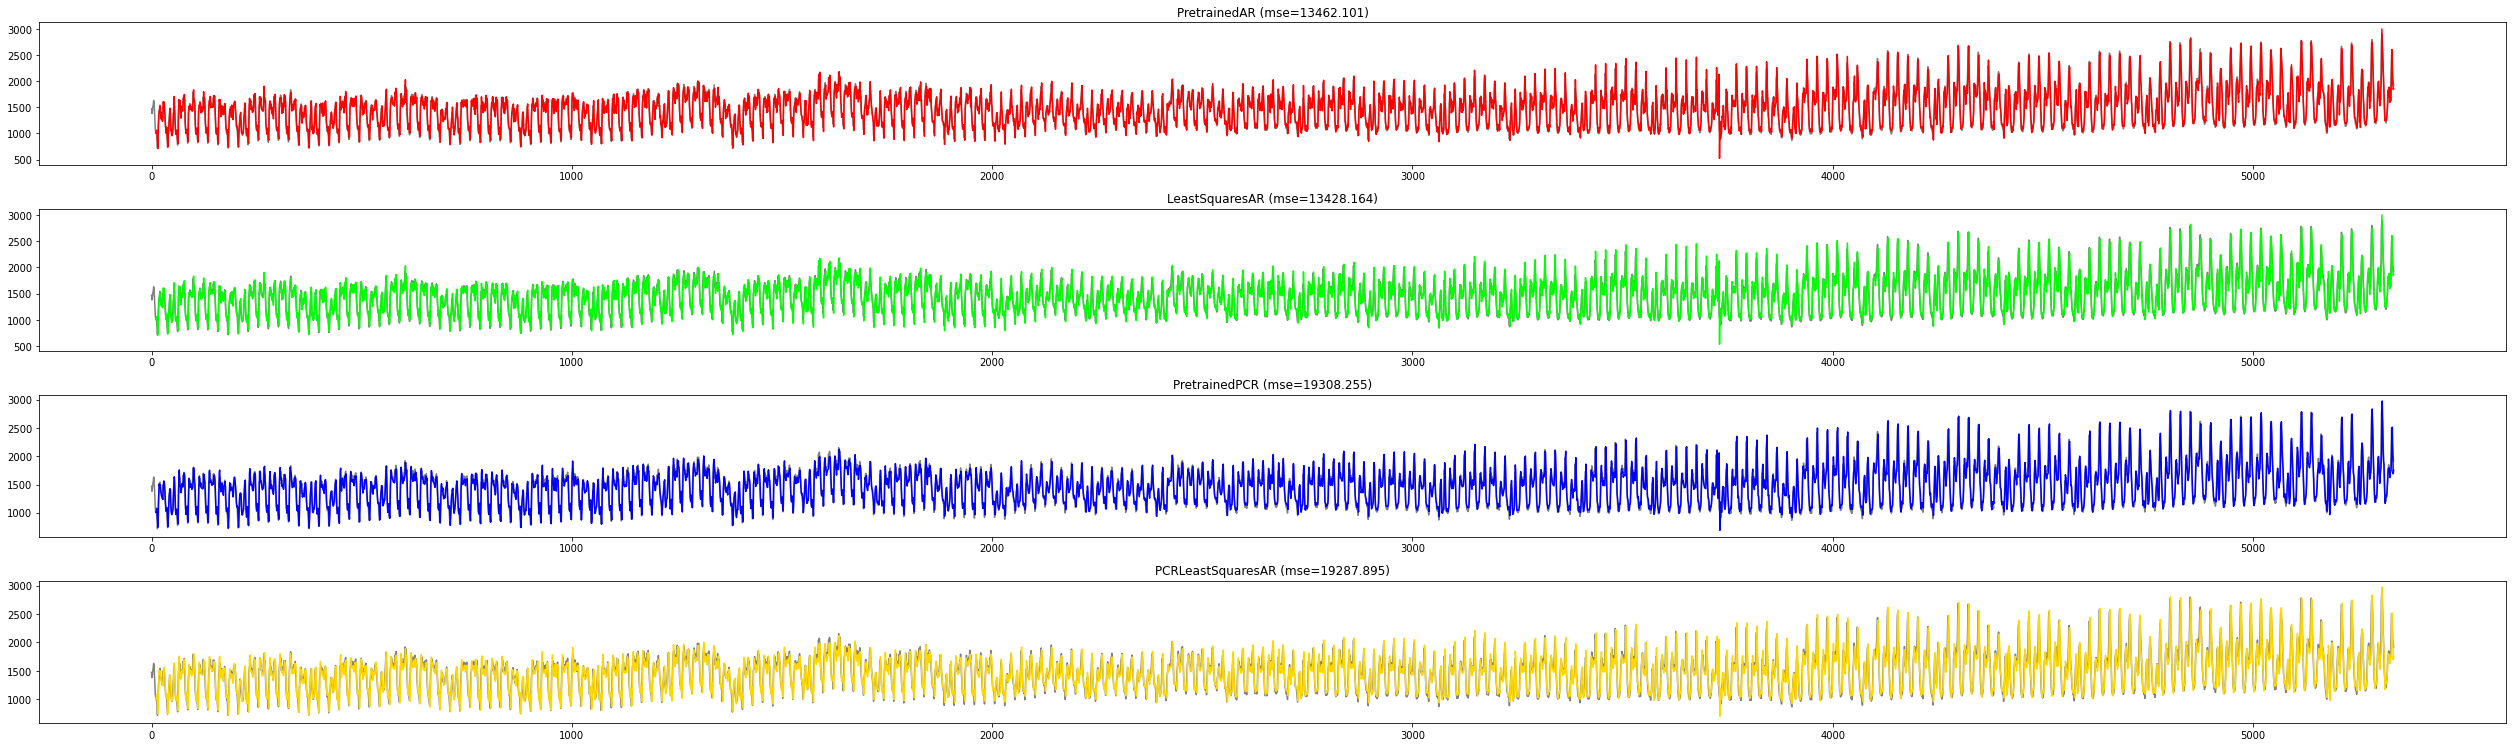

In [224]:
H = 10
k = 5

loss_table = []

num_figs = 7

plt.rc('figure', figsize=(num_figs * 5, 3*len(noise_levels)))

plt.subplot(num_figs, 1, 1)
loss_pretrained_ar = TestPretrainedAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 2)
loss_least_squares_ar = TestLeastSquaresAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 3)
loss_pretrained_pcr = TestPretrainedPCR(x_train, x_test, H, k)

plt.subplot(num_figs, 1, 4)
loss_pretrained_pcr_least_squares_ar = TestPCRLeastSquaresAR(x_train, x_test, H, k)

loss_pure = trunc_mse(x_test, x_pure[H:])

loss_table.append( [loss_pretrained_ar,
                    loss_least_squares_ar,
                    loss_pretrained_pcr,
                    loss_pcr_least_squares_ar,
                    loss_pure] )

loss_table = np.array(loss_table)
plt.tight_layout()

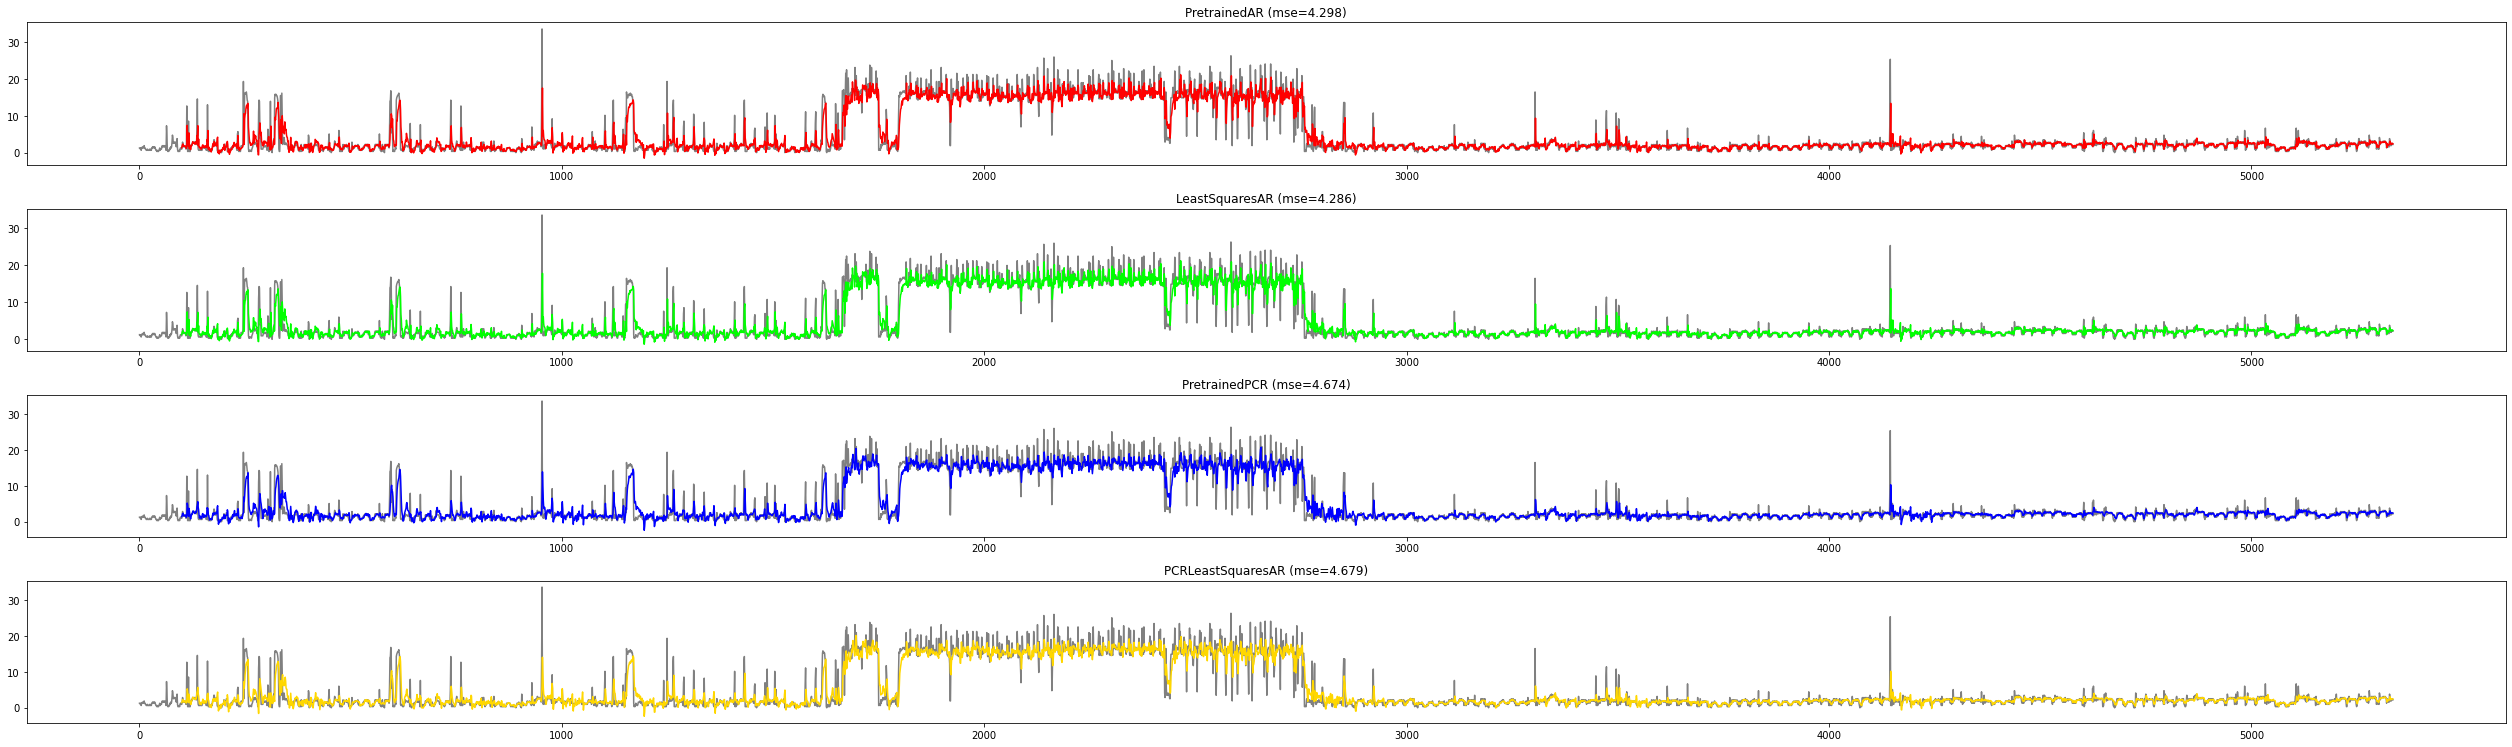

In [235]:
H = 100
k = 50

loss_table = []

num_figs = 7

plt.rc('figure', figsize=(num_figs * 5, 3*len(noise_levels)))

plt.subplot(num_figs, 1, 1)
loss_pretrained_ar = TestPretrainedAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 2)
loss_least_squares_ar = TestLeastSquaresAR(x_train, x_test, H)

plt.subplot(num_figs, 1, 3)
loss_pretrained_pcr = TestPretrainedPCR(x_train, x_test, H, k)

plt.subplot(num_figs, 1, 4)
loss_pretrained_pcr_least_squares_ar = TestPCRLeastSquaresAR(x_train, x_test, H, k)

loss_pure = trunc_mse(x_test, x_pure[H:])

loss_table.append( [loss_pretrained_ar,
                    loss_least_squares_ar,
                    loss_pretrained_pcr,
                    loss_pcr_least_squares_ar,
                    loss_pure] )

loss_table = np.array(loss_table)
plt.tight_layout()

In [238]:
# cutoff = 25968
cutoff = 20968
# x_train = np.array(data_3.iloc[:cutoff]).sum(axis=1)
# x_test = np.array(data_3.iloc[cutoff:]).sum(axis=1)

x_train = np.array(data_3.iloc[:cutoff])[:, 0]
x_test = np.array(data_3.iloc[cutoff:])[:, 0]

In [240]:
# Least Squares AR
plt.rc('figure', figsize=(8,4))

def TestLeastSquaresAR(x_train, x_test, H):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    ls = None
    if X_train.shape[0] > 0:
        ls = sklearn.linear_model.Ridge(1e-20)
        ls.fit(X_train, Y_train)
    
    Y_pred = []
    for x, y in tqdm.tqdm(zip(X_test, Y_test)):
        X_train, Y_train = list(X_train), list(Y_train)
        
        pred = y if ls is None else ls.predict(x.reshape(1, -1))
        Y_pred.append(pred)
        
        X_train.append(x)
        Y_train.append(y)
        ls = sklearn.linear_model.Ridge(1e-20)
        
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        ls.fit(X_train, Y_train)

    err = trunc_mse(Y_test, np.array(Y_pred).squeeze())
    viz(x_test, Y_pred, title='LeastSquaresAR (mse=%.3f)' % err, color='lime')

    return err, Y_pred

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.2974e-17): result may not be accurate.
  overwrite_a=False)
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.24182e-17): result may not be accurate.
  overwrite_a=False)
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.0359e-18): result may not be accurate.
  overwrite_a=False)
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.92372e-18): result may not be accurate.
  overwrite_a=False)
/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/sklearn/linear_

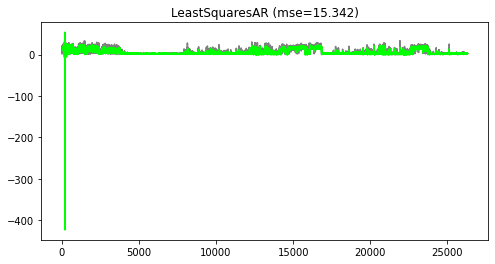

In [242]:
loss_least_squares_ar, ar_pred = TestLeastSquaresAR(x_train, x_test, H)

In [243]:
X_test, Y_test = AR_feat(x_test, H)

trunc_mse(Y_test[1000:], np.array(ar_pred[1000:]).flatten())

6.34364112597961